# Tool to shred simple PacBio subreads to simulate targeted sequencing

All reads longer than the threshold are broken into fragments using a random size distribution. 

To keep read depth the same, fragments are tiled across each long read. 

Read names are updated to match the spec (https://www.biostars.org/p/146048/#146135) by adjusting the start/stop in part 8 of the read name. 

```
m140415_143853_42175_c100635972550000001823121909121417_s1_p0/553/3100_11230 0.99 24
└1┘└─────2─────┘└──3─┘└────────────────4────────────────┘└5┘└6┘└7┘└────8────┘└─9─┘└10┘
```
1. "m" = movie
2. Time of Run Start (yymmdd_hhmmss)
3. Instrument Serial Number
4. SMRT Cell Barcode
5. Set Number (a.k.a. "Look Number". Deprecated field, used in earlier version of RS)
6. Part Number (usually "p0", "X0" when using expired reagents)
7. ZMW hole number
8. Subread Region (start_stop using polymerase read coordinates)
9. readScore
10. barcodeScore



## package loading, environment setup

In [2]:
suppressPackageStartupMessages({
    library(Biostrings)
    library(ggplot2)
    library(plotly)
    })
#fastaDir="/data/project/ccts/client/kimberly/ics1190_shred_reads/FCGR_PacBio_HGSVC_Trios"
fastaDir="./FCGR_PacBio_HGSVC_Trios"
if(!file.exists(fastaDir)){stop(paste0("fasta input dir missing: ", fastaDir))}else{cat("OK found",fastaDir,"\n")}

OK found ./FCGR_PacBio_HGSVC_Trios 


## scan for input files

In [3]:
inFileList = dir(fastaDir, pattern = "*.fa$", full.names = TRUE, ignore.case = TRUE)
cat(length(inFileList),"*.fa files found: ", basename(inFileList))

9 *.fa files found:  HG00512.fa HG00513.fa HG00514.fa HG00731.fa HG00732.fa HG00733.fa NA19238.fa NA19239.fa NA19240.fa

## Shredding parameters

In [9]:
shredSize =7000  # mean size of fragments
shredMax = 10000 # max size allowed out - size at which we shred, and max shred size.
shredMin = 300   # smallest fragment produced by shredding

## output directory creation

In [13]:
shredSubDir = paste0("shred_",shredMin,"_",shredSize,"_",shredMax)
if(!file.exists(file.path(fastaDir,shredSubDir))){dir.create(file.path(fastaDir,shredSubDir));cat("CREATED", shredSubDir)}else{cat("OK",shredSubDir)}

CREATED shred_300_7000_10000

## Read, shred and write *.fasta

In [20]:
fastaList = list()
shredList = list()
inWidthsDf = data.frame()
outWidthsDf = data.frame()
for( inFilename in inFileList ) {
  sampleName = gsub(basename(inFilename),pattern=".fa$",replacement="")
  outFilename = file.path(dirname(inFilename), shredSubDir, 
                          gsub(basename(inFilename),
                               pattern=".fa$",
                               replacement=paste0(".",shredSubDir,".fa")
                          ))

  cat("Reading ", inFilename, "\n" )
  fasta = readDNAStringSet(inFilename)
  comment(fasta)=c(inFilename=inFilename, sampleName=sampleName)
  fastaList[[sampleName]] = fasta
  inWidthsDf=rbind(inWidthsDf, data.frame(width=width(fasta),sample=sampleName,what="original"))
  
  fastaShredded = DNAStringSet()
  comment(fastaShredded)=c(comment(fasta),shredSize=shredSize, shredMax=shredMax)
  for(i in 1:length(fasta)) {
    seq = fasta[[i]]
    cat("\t[",i,"]\twidth=", length(seq), "\tname=", names(fasta)[i],"\n")
    if( length(seq) < shredMax ) {
      # don't shred things shorter than shredMax
      fastaShredded=append(fastaShredded,fasta[i])
    } else {
      # shreds long reads into shorter, non-overlapping segments (keep depth of coverage constant)
      # using a random distribution of shard lengths, with a mean at shredSize, and a max at shredMax
      seqName = names(fasta)[i]
      # note: DNAString uses 1-based counting
      fragLocs = subset(data.frame(width=floor(rnorm(n=1000,mean=shredSize,sd=(shredMax-shredSize)))), width<shredMax & width > shredMin)
      fragLocs$start = cumsum(c(1,head(fragLocs$width,-1)))
      #hist(fragLocs$width, breaks=100, xlim=c(0,shredMax))
      #plot(fragLocs)

      # truncate to only chunks fully inside
      #fragLocs = subset(fragLocs, start+width < length(seq))
      # truncate to only chunks partly inside, adjust last chunk's length
      iLast = tail(which(fragLocs$start<length(seq)),1)
      fragLocs=fragLocs[1:iLast,]
      fragLocs[iLast,]$width = length(seq)-fragLocs[iLast,]$start
      #plot(fragLocs[,c(2,1)])
      #fragLocs[,c(2,1)]
      
      # pull out those subsequences
      cat("\t\t shredding into ", nrow(fragLocs), " fragments: ", fragLocs$width,"\n")
      frags = DNAStringSet(seq, start=fragLocs$start, width=fragLocs$width)

      # name the frags - note that frags use 0-based counting
      seqNameParts = unlist(strsplit(seqName,split="/"))
      names(seqNameParts)=c("readName","zmwHoleNum","subreadRegion")
      subreadStart = as.integer(strsplit(seqNameParts["subreadRegion"],split="_")[[1]][1])
      shredLocStrs = paste(subreadStart+fragLocs$start-1,subreadStart+fragLocs$start-1+fragLocs$width, sep="_")
      names(frags) = paste(seqNameParts["readName"],seqNameParts["zmwHoleNum"],shredLocStrs,sep="/")
      
      # append that to output array
      fastaShredded=append(fastaShredded,frags)
    } #if(short)else(long)
  }# for each read
  
  # write out shreds
  cat("Done processing",inFilename, "\n")
  shredList[[sampleName]]=fastaShredded
  writeXStringSet(fastaShredded, format="fasta",outFilename)
  cat("Wrote ",outFilename,"\n")
  
  # compute widths for later plotting
  outWidthsDf=rbind(outWidthsDf, data.frame(width=width(fastaShredded),sample=sampleName,what="shredded"))
} # for each sample


Reading  /data/project/ccts/client/kimberly/ics1190_shred_reads/FCGR_PacBio_HGSVC_Trios/HG00512.fa 
	[ 1 ]	width= 16198 	name= m150823_152221_42220_c100827842550000001823175811251534_s1_p0/131840/0_16198 
		 shredding into  4  fragments:  2791 5435 3861 4110 
	[ 2 ]	width= 23415 	name= m150820_042014_42220_c100827762550000001823175811251544_s1_p0/31090/0_23415 
		 shredding into  6  fragments:  3595 6141 1793 2942 5296 3647 
	[ 3 ]	width= 32117 	name= m150905_000010_42220_c100827472550000001823175811251523_s1_p0/118883/0_32117 
		 shredding into  4  fragments:  8964 6110 9542 7500 
	[ 4 ]	width= 9218 	name= m150808_210245_42196_c100827822550000001823175811251551_s1_p0/106394/17629_26847 
	[ 5 ]	width= 17584 	name= m150808_210245_42196_c100827822550000001823175811251551_s1_p0/106394/0_17584 
		 shredding into  3  fragments:  5224 7376 4983 
	[ 6 ]	width= 11454 	name= m150922_053224_42220_c100816842550000001823176310291525_s1_p0/133466/0_11454 
		 shredding into  2  fragments:  7405 4048

## Plot sizes

### Before

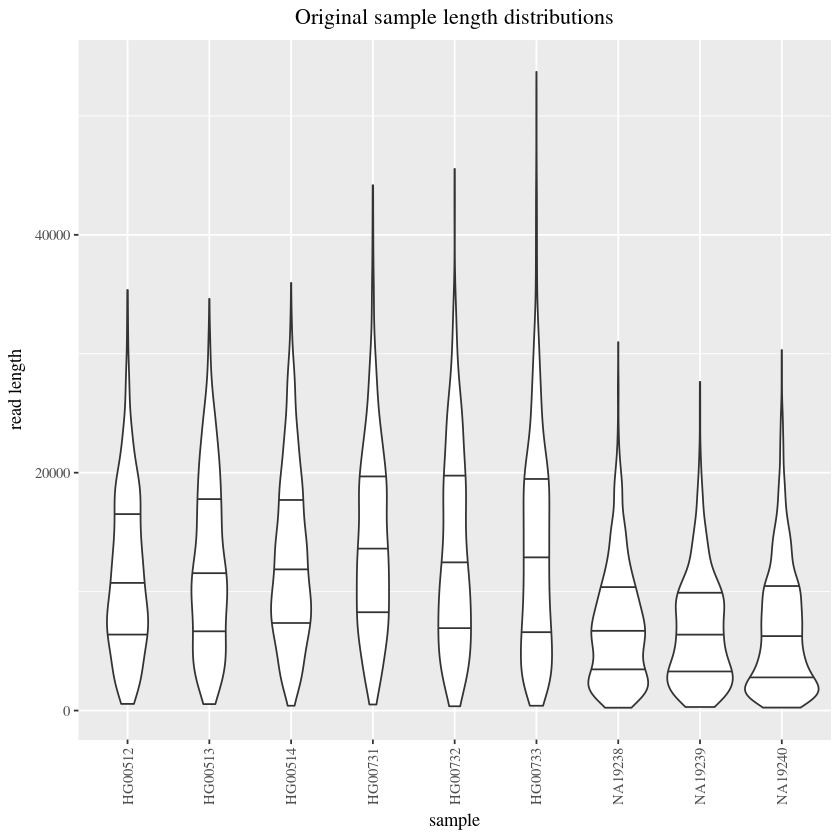

In [23]:
#
# plot lengths of original sequences
#
p <- ggplot(inWidthsDf, aes(factor(sample), width)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
  labs(y = "read length", x = "sample",
       title="Original sample length distributions") +
  theme(plot.title = element_text(hjust = 0.5))
p + geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))

In [24]:
# make interactive version
suppressMessages({ggplotly(p + geom_violin())})

HTML widgets cannot be represented in plain text (need html)

### After

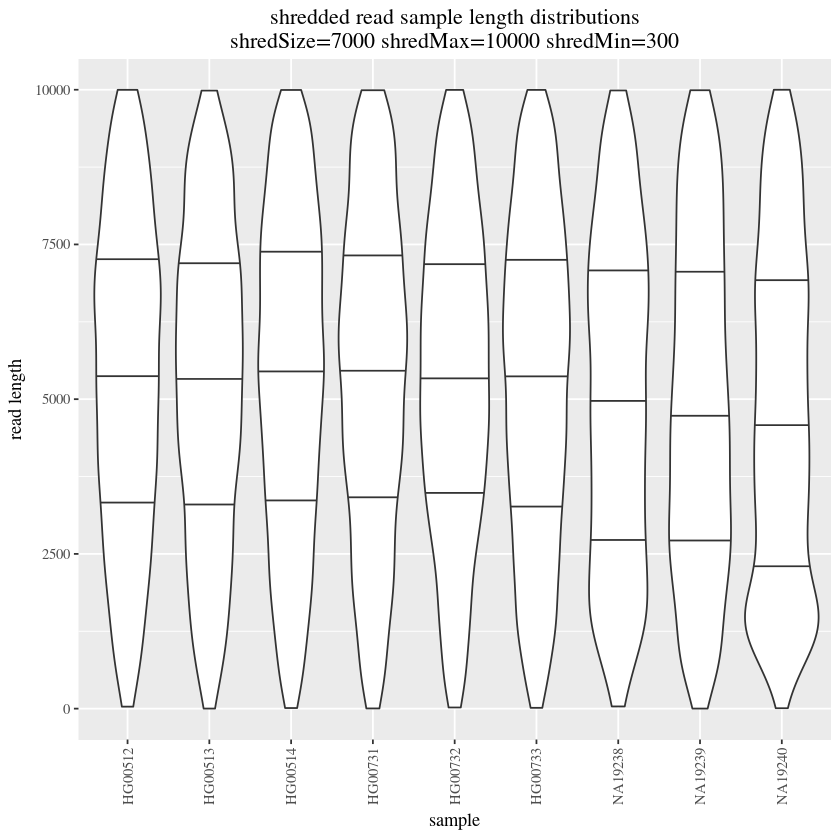

In [25]:
#
# plot lengths of shredded sequences
#
pp <- ggplot(outWidthsDf, aes(factor(sample), width)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
  labs(y = "read length", x = "sample",
       title=paste0("shredded read sample length distributions\n"
                   ,"shredSize=",shredSize
                   ," shredMax=", shredMax
                   ," shredMin=", shredMin) 
       )+
  theme(plot.title = element_text(hjust = 0.5))
pp + geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))


#### Before and After, side by side

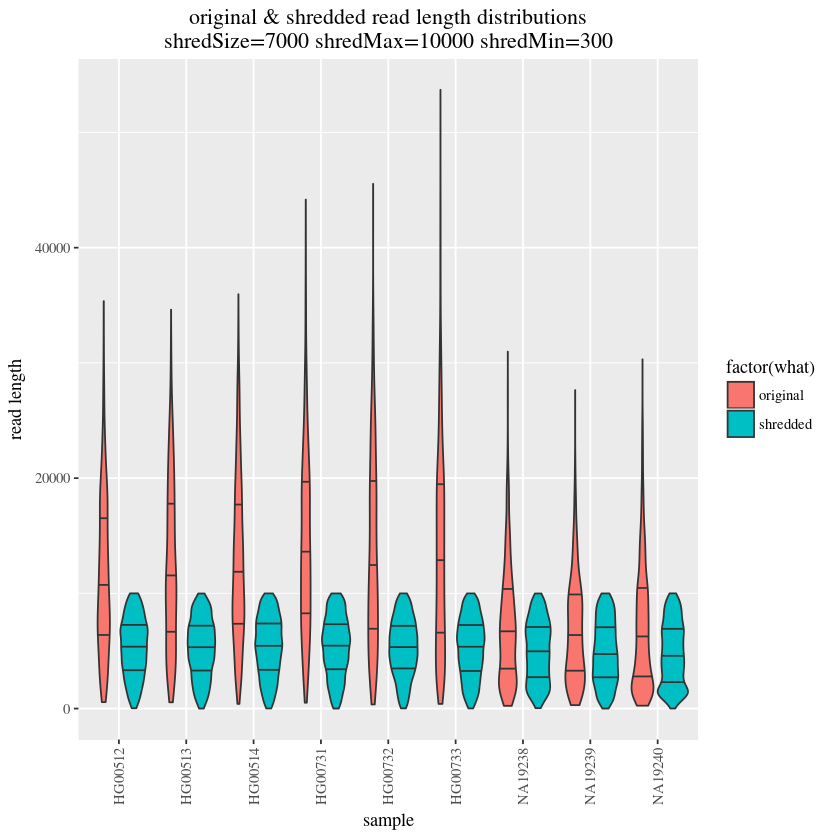

In [26]:
#
# combined plot lengths before/after shredded sequences
#
ppbf <- ggplot(rbind(inWidthsDf, outWidthsDf), aes(factor(sample), width, fill=factor(what))) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
  labs(y = "read length", x = "sample",
       title=paste0("original & shredded read length distributions\n"
                    ,"shredSize=",shredSize
                    ," shredMax=", shredMax
                    ," shredMin=", shredMin) 
  )+
  theme(plot.title = element_text(hjust = 0.5))
ppbf + geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
